# Doc 7 Dual Impact of Weight and Peneration

C:\Users\Ricky Chen\AppData\Local\Temp\ipykernel_6736\2841779172.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  set2_colors = cm.get_cmap('Set2')


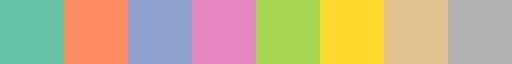

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

import matplotlib.cm as cm
set2_colors = cm.get_cmap('Set2')
set2_colors

## 1 Current weight growing scenario

### 1.1 Weight projection

In [2]:
# weight data
weight = pd.read_csv("data/weights_2016_2024.csv")
weight = weight[['year', 'ICEV & others', 'EV']]

In [3]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# linear function
def linear_func(x, a, b):
    return a * x + b

# fit data
## icev
x_icev = weight.loc[1:]['year'].values
y_icev = weight.loc[1:]['ICEV & others'].values
params_icev, params_covariance_icev = curve_fit(linear_func, x_icev, y_icev)
r2_icev = r2_score(y_icev, linear_func(x_icev, *params_icev))

## ev
x_ev = weight.loc[1:]['year'].values
y_ev = weight.loc[1:]['EV'].values
params_ev, params_covariance_ev = curve_fit(linear_func, x_ev, y_ev)
r2_ev = r2_score(y_ev, linear_func(x_ev, *params_ev))

In [4]:
from scipy import stats
# icev
slope_icev, intercept_icev, r_value_icev, p_value_icev, std_err_icev = stats.linregress(x_icev, y_icev)
# ev
slope_ev, intercept_ev, r_value_ev, p_value_ev, std_err_ev = stats.linregress(x_ev, y_ev)

p_value_icev, p_value_ev

(1.739188522835111e-05, 3.877033328431473e-06)

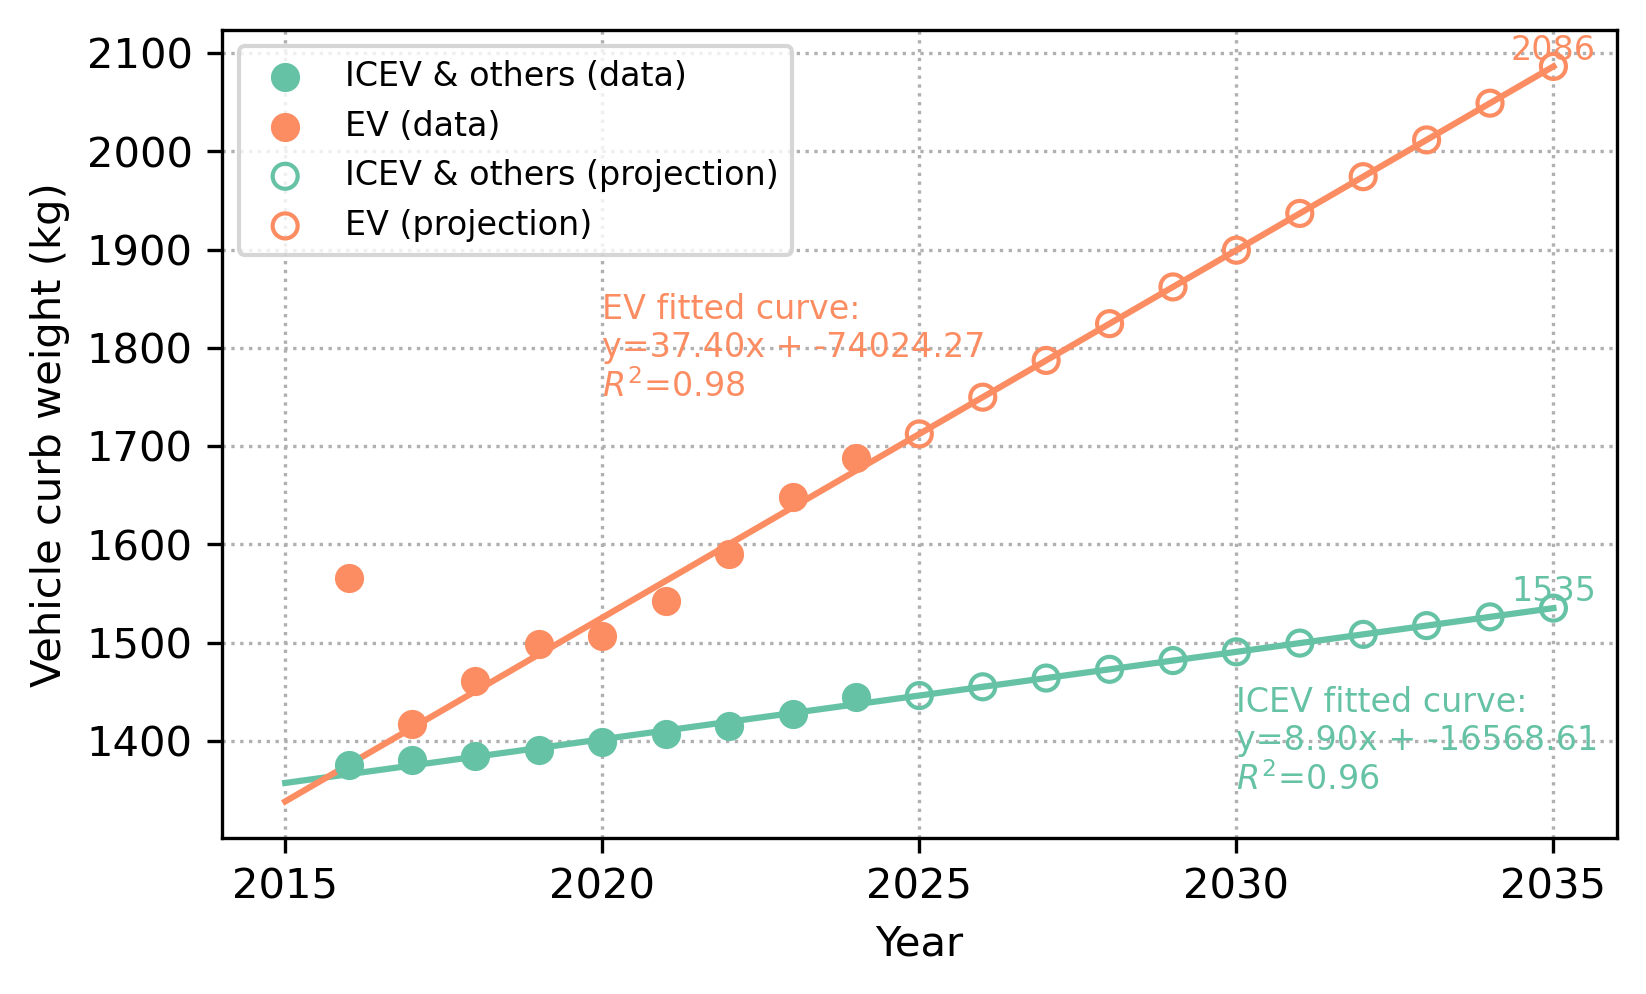

In [5]:
# Create figure
fig = plt.figure(figsize=(6,3.5))

ICEV_color = set2_colors(0)
EV_color = set2_colors(1)

# Plot raw data
plt.scatter(weight['year'], weight['ICEV & others'], color=ICEV_color, label='ICEV & others (data)', zorder=30)
plt.scatter(weight['year'], weight['EV'], color=EV_color, label='EV (data)', zorder=30)

# Plot projection data
x_proj = np.arange(2025, 2036, 1)
plt.scatter(x_proj, linear_func(x_proj, *params_icev), marker='o', facecolors='none', color=ICEV_color, label='ICEV & others (projection)', zorder=30)
plt.scatter(x_proj, linear_func(x_proj, *params_ev), marker='o', facecolors='none', color=EV_color, label='EV (projection)', zorder=30)
plt.text(2035, linear_func(2035, *params_icev), '%d'%(linear_func(2035, *params_icev)), ha='center', va='bottom', color=ICEV_color, fontsize=8)
plt.text(2035, linear_func(2035, *params_ev), '%d'%(linear_func(2035, *params_ev)), ha='center', va='bottom', color=EV_color, fontsize=8)

# Plot fitted curves
x = np.arange(2015, 2036, 1)
plt.plot(x, linear_func(x, *params_icev), color=ICEV_color, zorder=20)
plt.plot(x, linear_func(x, *params_ev), color=EV_color, zorder=20)

# text
plt.text(2030, 1350, f'ICEV fitted curve:\ny={params_icev[0]:.2f}x + {params_icev[1]:.2f}\n$R^2$={r2_icev:.2f}', color=ICEV_color, fontsize=8, zorder=20)
plt.text(2020, 1750, f'EV fitted curve:\ny={params_ev[0]:.2f}x + {params_ev[1]:.2f}\n$R^2$={r2_ev:.2f}', color=EV_color, fontsize=8, zorder=20)

# Add labels and title
plt.xticks(np.arange(2015, 2036,5))
plt.xlabel('Year')
plt.ylabel('Vehicle curb weight (kg)')
plt.legend(fontsize=8)
plt.grid(linestyle=":", zorder=10)

# Show plot
plt.show()
# fig.savefig('figures/vehicle weights projection.jpg', bbox_inches='tight', dpi=1000)

In [6]:
# projection
weight_proj = weight.copy()
for y in np.arange(2025, 2037, 1):
    weight_proj.loc[weight_proj.shape[0]] = [y, linear_func(y, *params_icev), linear_func(y, *params_ev)]
weight_proj = weight_proj[weight_proj['year'] >= 2023].reset_index(drop=True)

In [7]:
ev_2024 = weight_proj[weight_proj['year'] == 2024]['EV'].values
icev_2024 = weight_proj[weight_proj['year'] == 2024]['ICEV & others'].values
ev_2035 = weight_proj[weight_proj['year'] == 2035]['EV'].values
icev_2035 = weight_proj[weight_proj['year'] == 2035]['ICEV & others'].values
print("ICEV 2024 vs.2035: %.1f and %.1f" % (icev_2024, icev_2035))
print("EV 2024 vs.2035: %.1f and %.1f" % (ev_2024, ev_2035))
print("ICEV inc rate: %.2f%%" % ((icev_2035-icev_2024)/icev_2024*100))
print("EV inc rate: %.2f%%" % ((ev_2035-ev_2024)/ev_2024*100))

ICEV 2024 vs.2035: 1444.6 and 1535.1
EV 2024 vs.2035: 1687.9 and 2086.4
ICEV inc rate: 6.27%
EV inc rate: 23.61%


### 1.2 Weight adjust EFs

In [8]:
# EF data
with open("data/vehicle_ef_cltc.pkl", 'rb') as f:
    ef_cltc = pickle.load(f)
with open("data/vehicle_ef_chengdu.pkl", 'rb') as f:
    ef_chengdu = pickle.load(f)
# set 2024 as the base
base_ef_cltc = ef_cltc.loc[2024]
base_ef_chengdu = ef_chengdu.loc[2024]
# base weight
weight_2024_icev = weight_proj[weight_proj['year'] == 2024]['ICEV & others']
weight_2024_ev = weight_proj[weight_proj['year'] == 2024]['EV']

In [9]:
def weight_adjust(EF, weight, assumption, weight_ref):
    """
    Adjust calculated EF according to weight.
    """
    if assumption == 'linear':
        a = 1
    elif assumption == 'power':
        a = 1.9
    return EF * (weight/weight_ref)**(1/a)

In [10]:
proj_ef_cltc = weight_proj.copy()
proj_ef_cltc['ICEV EF linear'] = proj_ef_cltc.apply(lambda x: weight_adjust(base_ef_cltc['ICEV EF linear'], x['ICEV & others'], 'linear', weight_2024_icev), axis=1)
proj_ef_cltc['ICEV EF power'] = proj_ef_cltc.apply(lambda x: weight_adjust(base_ef_cltc['ICEV EF power'], x['ICEV & others'], 'power', weight_2024_icev), axis=1)
proj_ef_cltc['EV weak EF linear'] = proj_ef_cltc.apply(lambda x: weight_adjust(base_ef_cltc['EV weak EF linear'], x['EV'], 'linear', weight_2024_ev), axis=1)
proj_ef_cltc['EV weak EF power'] = proj_ef_cltc.apply(lambda x: weight_adjust(base_ef_cltc['EV weak EF power'], x['EV'], 'power', weight_2024_ev), axis=1)
proj_ef_cltc['EV strong EF linear'] = proj_ef_cltc.apply(lambda x: weight_adjust(base_ef_cltc['EV strong EF linear'], x['EV'], 'linear', weight_2024_ev), axis=1)
proj_ef_cltc['EV strong EF power'] = proj_ef_cltc.apply(lambda x: weight_adjust(base_ef_cltc['EV strong EF power'], x['EV'], 'power', weight_2024_ev), axis=1)

In [11]:
proj_ef_chengdu = weight_proj.copy()
proj_ef_chengdu['ICEV EF linear'] = proj_ef_chengdu.apply(lambda x: weight_adjust(base_ef_chengdu['ICEV EF linear'], x['ICEV & others'], 'linear', weight_2024_icev), axis=1)
proj_ef_chengdu['ICEV EF power'] = proj_ef_chengdu.apply(lambda x: weight_adjust(base_ef_chengdu['ICEV EF power'], x['ICEV & others'], 'power', weight_2024_icev), axis=1)
proj_ef_chengdu['EV weak EF linear'] = proj_ef_chengdu.apply(lambda x: weight_adjust(base_ef_chengdu['EV weak EF linear'], x['EV'], 'linear', weight_2024_ev), axis=1)
proj_ef_chengdu['EV weak EF power'] = proj_ef_chengdu.apply(lambda x: weight_adjust(base_ef_chengdu['EV weak EF power'], x['EV'], 'power', weight_2024_ev), axis=1)
proj_ef_chengdu['EV strong EF linear'] = proj_ef_chengdu.apply(lambda x: weight_adjust(base_ef_chengdu['EV strong EF linear'], x['EV'], 'linear', weight_2024_ev), axis=1)
proj_ef_chengdu['EV strong EF power'] = proj_ef_chengdu.apply(lambda x: weight_adjust(base_ef_chengdu['EV strong EF power'], x['EV'], 'power', weight_2024_ev), axis=1)

### 1.3 Penetration rate adjustment

In [12]:
pen_rate_range = np.arange(0,51,1) / 100 

EF

In [13]:
pen_proj_ef_cltc = pd.DataFrame(columns=['year', 'weight icev', 'weight ev', 'penetration', 'ev weak ef', 'ev strong ef'])
for pen in pen_rate_range:
    for index, row in proj_ef_cltc.iterrows():
        year = row['year']
        weight_icev = row['ICEV & others']
        weight_ev = row['EV']
        # weak reg
        ev_weak_ef_linear = row['ICEV EF linear'] * (1-pen) + row['EV weak EF linear'] * pen
        ev_weak_ef_power = row['ICEV EF power'] * (1-pen) + row['EV weak EF power'] * pen
        ev_weak_ef = (ev_weak_ef_linear + ev_weak_ef_power) / 2
        # strong reg
        ev_strong_ef_linear = row['ICEV EF linear'] * (1-pen) + row['EV strong EF linear'] * pen
        ev_strong_ef_power = row['ICEV EF power'] * (1-pen) + row['EV strong EF power'] * pen
        ev_strong_ef = (ev_strong_ef_linear + ev_strong_ef_power) / 2
        # add row
        pen_proj_ef_cltc.loc[pen_proj_ef_cltc.shape[0]] = [year, weight_icev, weight_ev, pen, ev_weak_ef, ev_strong_ef]
pen_proj_ef_cltc['ef'] = (pen_proj_ef_cltc['ev weak ef'] + pen_proj_ef_cltc['ev strong ef']) / 2

In [14]:
pen_proj_ef_chengdu = pd.DataFrame(columns=['year', 'weight icev', 'weight ev', 'penetration', 'ev weak ef', 'ev strong ef'])
for pen in pen_rate_range:
    for index, row in proj_ef_chengdu.iterrows():
        year = row['year']
        weight_icev = row['ICEV & others']
        weight_ev = row['EV']
        # weak reg
        ev_weak_ef_linear = row['ICEV EF linear'] * (1-pen) + row['EV weak EF linear'] * pen
        ev_weak_ef_power = row['ICEV EF power'] * (1-pen) + row['EV weak EF power'] * pen
        ev_weak_ef = (ev_weak_ef_linear + ev_weak_ef_power) / 2
        # strong reg
        ev_strong_ef_linear = row['ICEV EF linear'] * (1-pen) + row['EV strong EF linear'] * pen
        ev_strong_ef_power = row['ICEV EF power'] * (1-pen) + row['EV strong EF power'] * pen
        ev_strong_ef = (ev_strong_ef_linear + ev_strong_ef_power) / 2
        # add row
        pen_proj_ef_chengdu.loc[pen_proj_ef_chengdu.shape[0]] = [year, weight_icev, weight_ev, pen, ev_weak_ef, ev_strong_ef]
pen_proj_ef_chengdu['ef'] = (pen_proj_ef_chengdu['ev weak ef'] + pen_proj_ef_chengdu['ev strong ef']) / 2

EF increasing rate compared to 2024

In [15]:
# EF difference
pen_proj_ef_inc_cltc = pen_proj_ef_cltc.copy()
ef_2024_cltc = pen_proj_ef_cltc[(pen_proj_ef_cltc['year'] == 2024) & (pen_proj_ef_cltc['penetration'] == 0.09)]
pen_proj_ef_inc_cltc["ev weak ef"] = (pen_proj_ef_inc_cltc["ev weak ef"] - ef_2024_cltc['ev weak ef'].values[0]) / ef_2024_cltc['ev weak ef'].values[0]
pen_proj_ef_inc_cltc["ev strong ef"] = (pen_proj_ef_inc_cltc["ev strong ef"] - ef_2024_cltc['ev strong ef'].values[0]) / ef_2024_cltc['ev strong ef'].values[0]
pen_proj_ef_inc_cltc["ef"] = (pen_proj_ef_inc_cltc["ef"] - ef_2024_cltc['ef'].values[0]) / ef_2024_cltc['ef'].values[0]

In [16]:
# EF difference
pen_proj_ef_inc_chengdu = pen_proj_ef_chengdu.copy()
ef_2024_chengdu = pen_proj_ef_chengdu[(pen_proj_ef_chengdu['year'] == 2024) & (pen_proj_ef_chengdu['penetration'] == 0.09)]
pen_proj_ef_inc_chengdu["ev weak ef"] = (pen_proj_ef_inc_chengdu["ev weak ef"] - ef_2024_chengdu['ev weak ef'].values[0]) / ef_2024_chengdu['ev weak ef'].values[0]
pen_proj_ef_inc_chengdu["ev strong ef"] = (pen_proj_ef_inc_chengdu["ev strong ef"] - ef_2024_chengdu['ev strong ef'].values[0]) / ef_2024_chengdu['ev strong ef'].values[0]
pen_proj_ef_inc_chengdu["ef"] = (pen_proj_ef_inc_chengdu["ef"] - ef_2024_chengdu['ef'].values[0]) / ef_2024_chengdu['ef'].values[0]

Plot

In [17]:
# penetration data
penetration = pd.read_excel("data/ev_penetration.xlsx")
base_penetration = penetration.iloc[-1]['penetration']

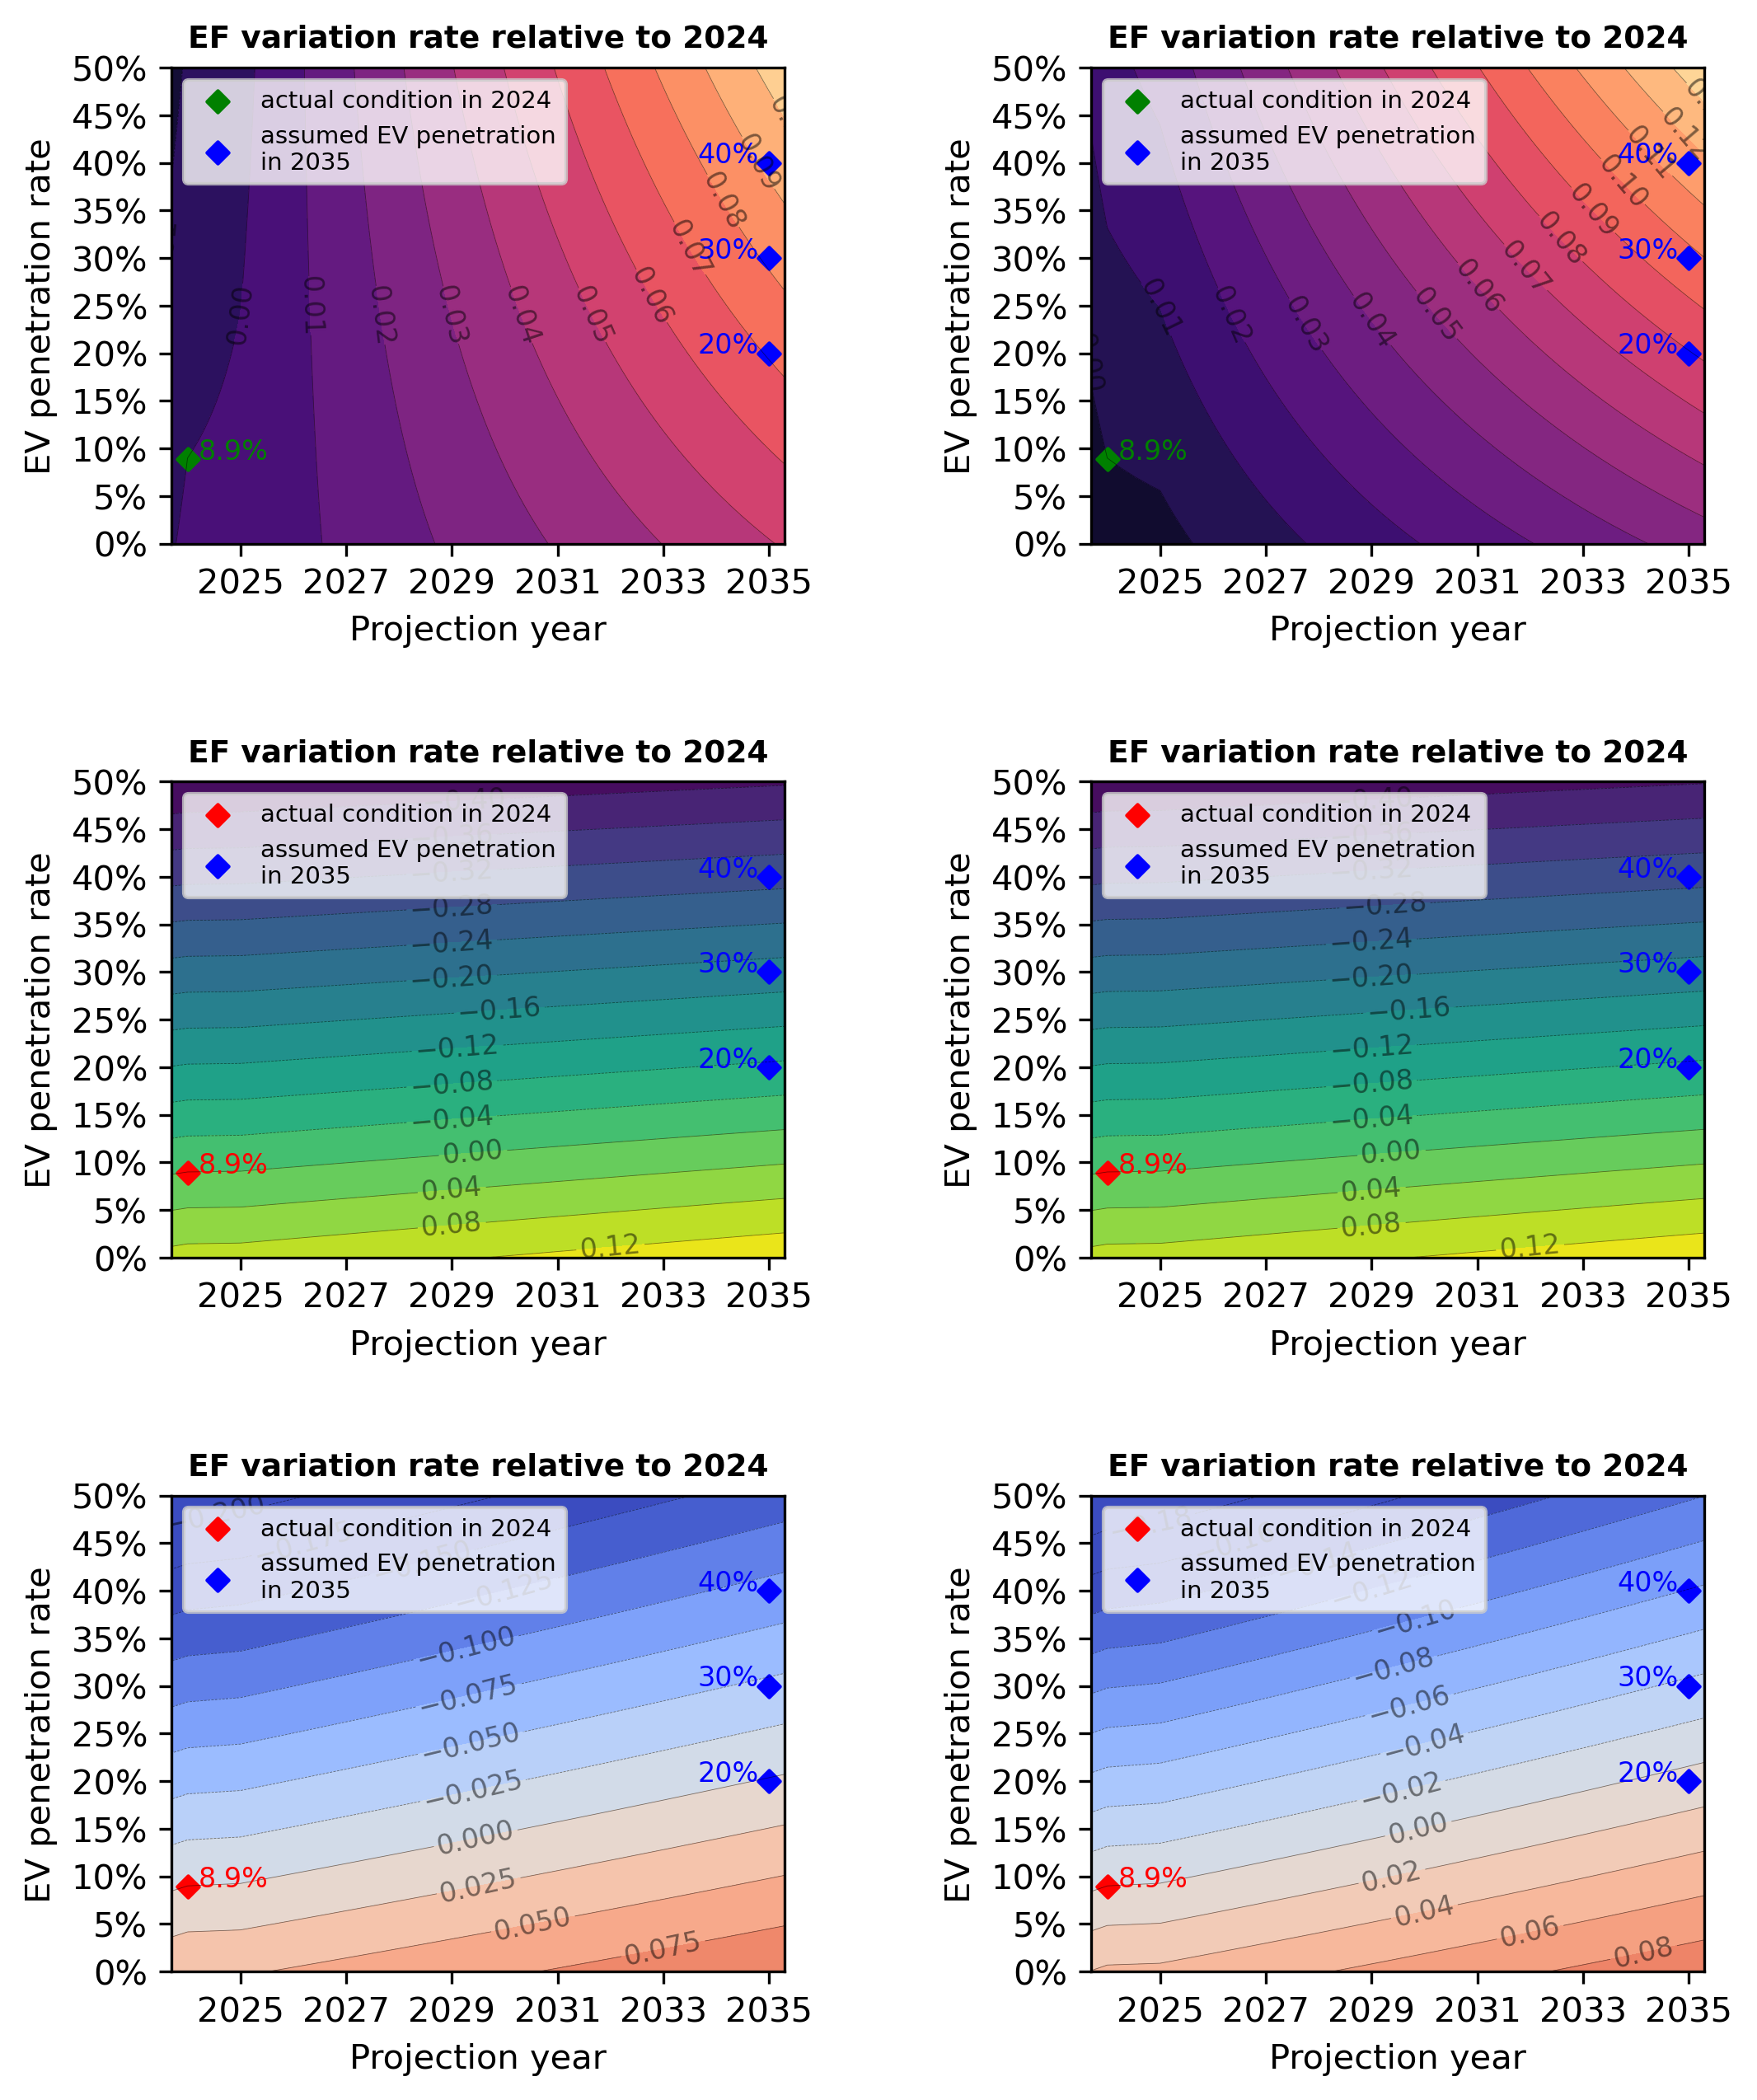

In [18]:
# plot
fig, axes = plt.subplots(3,2,figsize=(8,10))
(ax1, ax2, ax3, ax4, ax5, ax6) = axes.flatten()

x_ticks_range = np.arange(2025, 2036, 2)
y_ticks_range = np.arange(0,51,5) / 100 

def contour(ax, ef, ef_name, cmap):
    pivot_ef = ef.pivot(index='penetration', columns='year', values=ef_name)
    X, Y = np.meshgrid(pivot_ef.columns, pivot_ef.index)
    if ef_name == "ef":
        contourf = ax.contourf(X, Y, pivot_ef.values, cmap=cmap, levels=15, vmin=-0.15, vmax=0.15)
        contour = ax.contour(X, Y, pivot_ef.values, colors='k', alpha=0.5, linewidths=0.2, levels=15, vmin=-0.15, vmax=0.15)
    else:
        contourf = ax.contourf(X, Y, pivot_ef.values, cmap=cmap, levels=15)
        contour = ax.contour(X, Y, pivot_ef.values, colors='k', alpha=0.5, linewidths=0.2, levels=15)       
    ax.clabel(contour, inline=True, fontsize=8)
    ax.set_title("EF variation rate relative to 2024", fontsize=9, fontweight='bold')
    ax.set_xlabel('Projection year')
    ax.set_ylabel('EV penetration rate')
    ax.set_xticks(x_ticks_range, ["%d" % year for year in x_ticks_range])
    ax.set_yticks(y_ticks_range, ["%d%%" % pen for pen in y_ticks_range*100], rotation=0)
    ax.set_xlim(2023.7,2035.3)

def scatter(ax, ef, ef_name, dot_color):
    # actual penetration
    ax.scatter([2024], [base_penetration], marker='D', color=dot_color, s=20, label='actual condition in 2024')
    ax.text(2024+0.2, base_penetration, '%.1f%%'%(base_penetration*100), ha='left', color=dot_color, fontsize=8)
    # expected penetration
    exp_pen = [0.20, 0.30, 0.40]
    ax.scatter([2035, 2035, 2035], exp_pen, marker='D', color='b', s=20, label='assumed EV penetration\nin 2035')
    for x,y in zip([2035, 2035, 2035], exp_pen):
        ax.text(x-0.2, y, '%d%%'%(y*100), ha='right', color='b', fontsize=8)
    ax.legend(loc='upper left', fontsize=7, shadow=False)

# fig 1: cltc-p weak
contour(ax1, pen_proj_ef_inc_cltc, "ev weak ef", 'magma')
scatter(ax1, pen_proj_ef_inc_cltc, "ev weak ef", 'g')
# fig 2: chengdu weak
contour(ax2, pen_proj_ef_inc_chengdu, "ev weak ef", 'magma')
scatter(ax2, pen_proj_ef_inc_chengdu, "ev weak ef", 'g')
# fig 3: cltc-p strong
contour(ax3, pen_proj_ef_inc_cltc, "ev strong ef", 'viridis')
scatter(ax3, pen_proj_ef_inc_cltc, "ev strong ef", 'r')
# fig 4: chengdu strong
contour(ax4, pen_proj_ef_inc_chengdu, "ev strong ef", 'viridis')
scatter(ax4, pen_proj_ef_inc_chengdu, "ev strong ef", 'r')
# fig 6: cltc-p mean
contour(ax5, pen_proj_ef_inc_cltc, "ef", 'coolwarm')
scatter(ax5, pen_proj_ef_inc_cltc, "ef", 'r')
# fig 6: chengdu mean
contour(ax6, pen_proj_ef_inc_chengdu, "ef", 'coolwarm')
scatter(ax6, pen_proj_ef_inc_chengdu, "ef", 'r')

plt.subplots_adjust(
    wspace=0.5,
    hspace=0.5
)
plt.show()
# fig.savefig('figures/dual impact - weight projection.jpg', bbox_inches='tight', dpi=1000)

In [19]:
pen_proj_ef_inc_cltc[(pen_proj_ef_inc_cltc['year'] == 2035) & (pen_proj_ef_inc_cltc['penetration'].isin([0.20, 0.30, 0.40]))]

,year,weight icev,weight ev,penetration,ev weak ef,ev strong ef,ef
typing.Literal[<no_default>],,,,,,,
292,2035.0,1535.109288,2086.41196,0.2,0.070719,-0.073674,0.001738
432,2035.0,1535.109288,2086.41196,0.3,0.081344,-0.184170,-0.045500
572,2035.0,1535.109288,2086.41196,0.4,0.091969,-0.294667,-0.092738


In [20]:
pen_proj_ef_cltc[(pen_proj_ef_cltc['year'] == 2035) & (pen_proj_ef_cltc['penetration'].isin([0.20, 0.30, 0.40]))]

,year,weight icev,weight ev,penetration,ev weak ef,ev strong ef,ef
292,2035.0,1535.109288,2086.41196,0.2,1.347690,1.066507,1.207099
432,2035.0,1535.109288,2086.41196,0.3,1.361064,0.939289,1.150177
572,2035.0,1535.109288,2086.41196,0.4,1.374437,0.812071,1.093254


In [21]:
pen_proj_ef_inc_chengdu[(pen_proj_ef_inc_chengdu['year'] == 2035) & (pen_proj_ef_inc_chengdu['penetration'].isin([0.20, 0.30, 0.40]))]

,year,weight icev,weight ev,penetration,ev weak ef,ev strong ef,ef
typing.Literal[<no_default>],,,,,,,
292,2035.0,1535.109288,2086.41196,0.2,0.079451,-0.073107,0.006772
432,2035.0,1535.109288,2086.41196,0.3,0.097401,-0.183129,-0.036244
572,2035.0,1535.109288,2086.41196,0.4,0.115351,-0.293151,-0.079260


In [22]:
pen_proj_ef_chengdu[(pen_proj_ef_chengdu['year'] == 2035) & (pen_proj_ef_chengdu['penetration'].isin([0.20, 0.30, 0.40]))]

,year,weight icev,weight ev,penetration,ev weak ef,ev strong ef,ef
292,2035.0,1535.109288,2086.41196,0.2,31.537062,24.638966,28.088014
432,2035.0,1535.109288,2086.41196,0.3,32.061481,21.714336,26.887909
572,2035.0,1535.109288,2086.41196,0.4,32.585899,18.789707,25.687803


In [23]:
pen_proj_ef_inc_cltc[(pen_proj_ef_inc_cltc['year'] == 2035) & (pen_proj_ef_inc_cltc['penetration'].isin([0.28]))]

,year,weight icev,weight ev,penetration,ev weak ef,ev strong ef,ef
typing.Literal[<no_default>],,,,,,,
404,2035.0,1535.109288,2086.41196,0.28,0.079219,-0.162071,-0.036052


In [24]:
pen_proj_ef_cltc[(pen_proj_ef_cltc['year'] == 2035) & (pen_proj_ef_cltc['penetration'].isin([0.28]))]

,year,weight icev,weight ev,penetration,ev weak ef,ev strong ef,ef
404,2035.0,1535.109288,2086.41196,0.28,1.358389,0.964733,1.161561


In [25]:
pen_proj_ef_inc_chengdu[(pen_proj_ef_inc_chengdu['year'] == 2035) & (pen_proj_ef_inc_chengdu['penetration'].isin([0.28]))]

,year,weight icev,weight ev,penetration,ev weak ef,ev strong ef,ef
typing.Literal[<no_default>],,,,,,,
404,2035.0,1535.109288,2086.41196,0.28,0.093811,-0.161125,-0.027641


In [26]:
pen_proj_ef_chengdu[(pen_proj_ef_chengdu['year'] == 2035) & (pen_proj_ef_chengdu['penetration'].isin([0.28]))]

,year,weight icev,weight ev,penetration,ev weak ef,ev strong ef,ef
404,2035.0,1535.109288,2086.41196,0.28,31.956597,22.299262,27.12793


---

## 2 Weight control sensitivity

In [27]:
# EF data
with open("data/vehicle_ef_cltc.pkl", 'rb') as f:
    ef_cltc = pickle.load(f)
with open("data/vehicle_ef_chengdu.pkl", 'rb') as f:
    ef_chengdu = pickle.load(f)

In [28]:
# set 2024 as the base
base_ef_cltc = ef_cltc.loc[2024]
base_ef_chengdu = ef_chengdu.loc[2024]

### 2.1 Weight adjustment

In [29]:
# weight data
weight = pd.read_csv("data/weights_2016_2024.csv")
weight_2024 = weight.iloc[-1]
weight_2024_icev = weight_2024['ICEV & others']
weight_2024_ev = weight_2024['EV']
weight_2035_icev = weight_proj[weight_proj['year']==2035]['ICEV & others'].values[0]

In [30]:
def weight_adjust(EF, weight, assumption, weight_ref):
    """
    Adjust calculated EF according to weight.
    """
    if assumption == 'linear':
        a = 1
    elif assumption == 'power':
        a = 1.9
    return EF * (weight/weight_ref)**(1/a)

In [31]:
weight_inc_range = np.arange(-100, 401, 10)

In [32]:
weight_adjust_ef_cltc = pd.DataFrame(columns=['weight inc', 'ICEV EF linear', 'ICEV EF power', 'EV weak EF linear', 'EV weak EF power', 'EV strong EF linear', 'EV strong EF power'])
for inc in weight_inc_range:
    icev_ef_linear = weight_adjust(base_ef_cltc['ICEV EF linear'], weight_2035_icev, 'linear', weight_2024_icev)
    icev_ef_power = weight_adjust(base_ef_cltc['ICEV EF power'], weight_2035_icev, 'power', weight_2024_icev)
    ev_weak_ef_linear = weight_adjust(base_ef_cltc['EV weak EF linear'], weight_2024_ev+inc, 'linear', weight_2024_ev)
    ev_weak_ef_power = weight_adjust(base_ef_cltc['EV weak EF power'], weight_2024_ev+inc, 'power', weight_2024_ev)
    ev_strong_ef_linear = weight_adjust(base_ef_cltc['EV strong EF linear'], weight_2024_ev+inc, 'linear', weight_2024_ev)
    ev_strong_ef_power = weight_adjust(base_ef_cltc['EV strong EF power'], weight_2024_ev+inc, 'power', weight_2024_ev)
    weight_adjust_ef_cltc.loc[weight_adjust_ef_cltc.shape[0]] = [inc, icev_ef_linear, icev_ef_power, ev_weak_ef_linear, ev_weak_ef_power, ev_strong_ef_linear, ev_strong_ef_power]

In [33]:
weight_adjust_ef_chengdu = pd.DataFrame(columns=['weight inc', 'ICEV EF linear', 'ICEV EF power', 'EV weak EF linear', 'EV weak EF power', 'EV strong EF linear', 'EV strong EF power'])
for inc in weight_inc_range:
    icev_ef_linear = weight_adjust(base_ef_chengdu['ICEV EF linear'], weight_2035_icev, 'linear', weight_2024_icev)
    icev_ef_power = weight_adjust(base_ef_chengdu['ICEV EF power'], weight_2035_icev, 'power', weight_2024_icev)
    ev_weak_ef_linear = weight_adjust(base_ef_chengdu['EV weak EF linear'], weight_2024_ev+inc, 'linear', weight_2024_ev)
    ev_weak_ef_power = weight_adjust(base_ef_chengdu['EV weak EF power'], weight_2024_ev+inc, 'power', weight_2024_ev)
    ev_strong_ef_linear = weight_adjust(base_ef_chengdu['EV strong EF linear'], weight_2024_ev+inc, 'linear', weight_2024_ev)
    ev_strong_ef_power = weight_adjust(base_ef_chengdu['EV strong EF power'], weight_2024_ev+inc, 'power', weight_2024_ev)
    weight_adjust_ef_chengdu.loc[weight_adjust_ef_chengdu.shape[0]] = [inc, icev_ef_linear, icev_ef_power, ev_weak_ef_linear, ev_weak_ef_power, ev_strong_ef_linear, ev_strong_ef_power]

### 2.2 Penetration rate adjustment

In [34]:
# data
penetration = pd.read_excel("data/ev_penetration.xlsx")
base_penetration = penetration.iloc[-1]['penetration']

In [35]:
pen_rate_range = np.arange(0,51,1) / 100 

EF

In [36]:
pen_weight_adjust_ef_cltc = pd.DataFrame(columns=['weight inc', 'penetration', 'ev weak ef', 'ev strong ef'])
for pen in pen_rate_range:
    for index, row in weight_adjust_ef_cltc.iterrows():
        weight_inc = row['weight inc']
        # weak reg
        ev_weak_ef_linear = row['ICEV EF linear'] * (1-pen) + row['EV weak EF linear'] * pen
        ev_weak_ef_power = row['ICEV EF power'] * (1-pen) + row['EV weak EF power'] * pen
        ev_weak_ef = (ev_weak_ef_linear + ev_weak_ef_power) / 2
        # strong reg
        ev_strong_ef_linear = row['ICEV EF linear'] * (1-pen) + row['EV strong EF linear'] * pen
        ev_strong_ef_power = row['ICEV EF power'] * (1-pen) + row['EV strong EF power'] * pen
        ev_strong_ef = (ev_strong_ef_linear + ev_strong_ef_power) / 2
        # add row
        pen_weight_adjust_ef_cltc.loc[pen_weight_adjust_ef_cltc.shape[0]] = [weight_inc, pen, ev_weak_ef, ev_strong_ef]
pen_weight_adjust_ef_cltc['ef'] = (pen_weight_adjust_ef_cltc['ev weak ef'] + pen_weight_adjust_ef_cltc['ev strong ef']) / 2

In [37]:
pen_weight_adjust_ef_chengdu = pd.DataFrame(columns=['weight inc', 'penetration', 'ev weak ef', 'ev strong ef'])
for pen in pen_rate_range:
    for index, row in weight_adjust_ef_chengdu.iterrows():
        weight_inc = row['weight inc']
        # weak reg
        ev_weak_ef_linear = row['ICEV EF linear'] * (1-pen) + row['EV weak EF linear'] * pen
        ev_weak_ef_power = row['ICEV EF power'] * (1-pen) + row['EV weak EF power'] * pen
        ev_weak_ef = (ev_weak_ef_linear + ev_weak_ef_power) / 2
        # strong reg
        ev_strong_ef_linear = row['ICEV EF linear'] * (1-pen) + row['EV strong EF linear'] * pen
        ev_strong_ef_power = row['ICEV EF power'] * (1-pen) + row['EV strong EF power'] * pen
        ev_strong_ef = (ev_strong_ef_linear + ev_strong_ef_power) / 2
        # add row
        pen_weight_adjust_ef_chengdu.loc[pen_weight_adjust_ef_chengdu.shape[0]] = [weight_inc, pen, ev_weak_ef, ev_strong_ef]
pen_weight_adjust_ef_chengdu['ef'] = (pen_weight_adjust_ef_chengdu['ev weak ef'] + pen_weight_adjust_ef_chengdu['ev strong ef']) / 2

EF inc compared to 2024

In [38]:
# EF difference
pen_weight_adjust_ef_inc_cltc = pen_weight_adjust_ef_cltc.copy()
ef_2024_cltc = pen_proj_ef_cltc[(pen_proj_ef_cltc['year'] == 2024) & (pen_proj_ef_cltc['penetration'] == 0.09)]
pen_weight_adjust_ef_inc_cltc["ev weak ef"] = (pen_weight_adjust_ef_inc_cltc["ev weak ef"] - ef_2024_cltc['ev weak ef'].values[0]) / ef_2024_cltc['ev weak ef'].values[0]
pen_weight_adjust_ef_inc_cltc["ev strong ef"] = (pen_weight_adjust_ef_inc_cltc["ev strong ef"] - ef_2024_cltc['ev strong ef'].values[0]) / ef_2024_cltc['ev strong ef'].values[0]
pen_weight_adjust_ef_inc_cltc["ef"] = (pen_weight_adjust_ef_inc_cltc["ef"] - ef_2024_cltc['ef'].values[0]) / ef_2024_cltc['ef'].values[0]

In [39]:
# EF difference
pen_weight_adjust_ef_inc_chengdu = pen_weight_adjust_ef_chengdu.copy()
ef_2024_chengdu = pen_proj_ef_chengdu[(pen_proj_ef_chengdu['year'] == 2024) & (pen_proj_ef_chengdu['penetration'] == 0.09)]
pen_weight_adjust_ef_inc_chengdu["ev weak ef"] = (pen_weight_adjust_ef_inc_chengdu["ev weak ef"] - ef_2024_chengdu['ev weak ef'].values[0]) / ef_2024_chengdu['ev weak ef'].values[0]
pen_weight_adjust_ef_inc_chengdu["ev strong ef"] = (pen_weight_adjust_ef_inc_chengdu["ev strong ef"] - ef_2024_chengdu['ev strong ef'].values[0]) / ef_2024_chengdu['ev strong ef'].values[0]
pen_weight_adjust_ef_inc_chengdu["ef"] = (pen_weight_adjust_ef_inc_chengdu["ef"] - ef_2024_chengdu['ef'].values[0]) / ef_2024_chengdu['ef'].values[0]

Plot

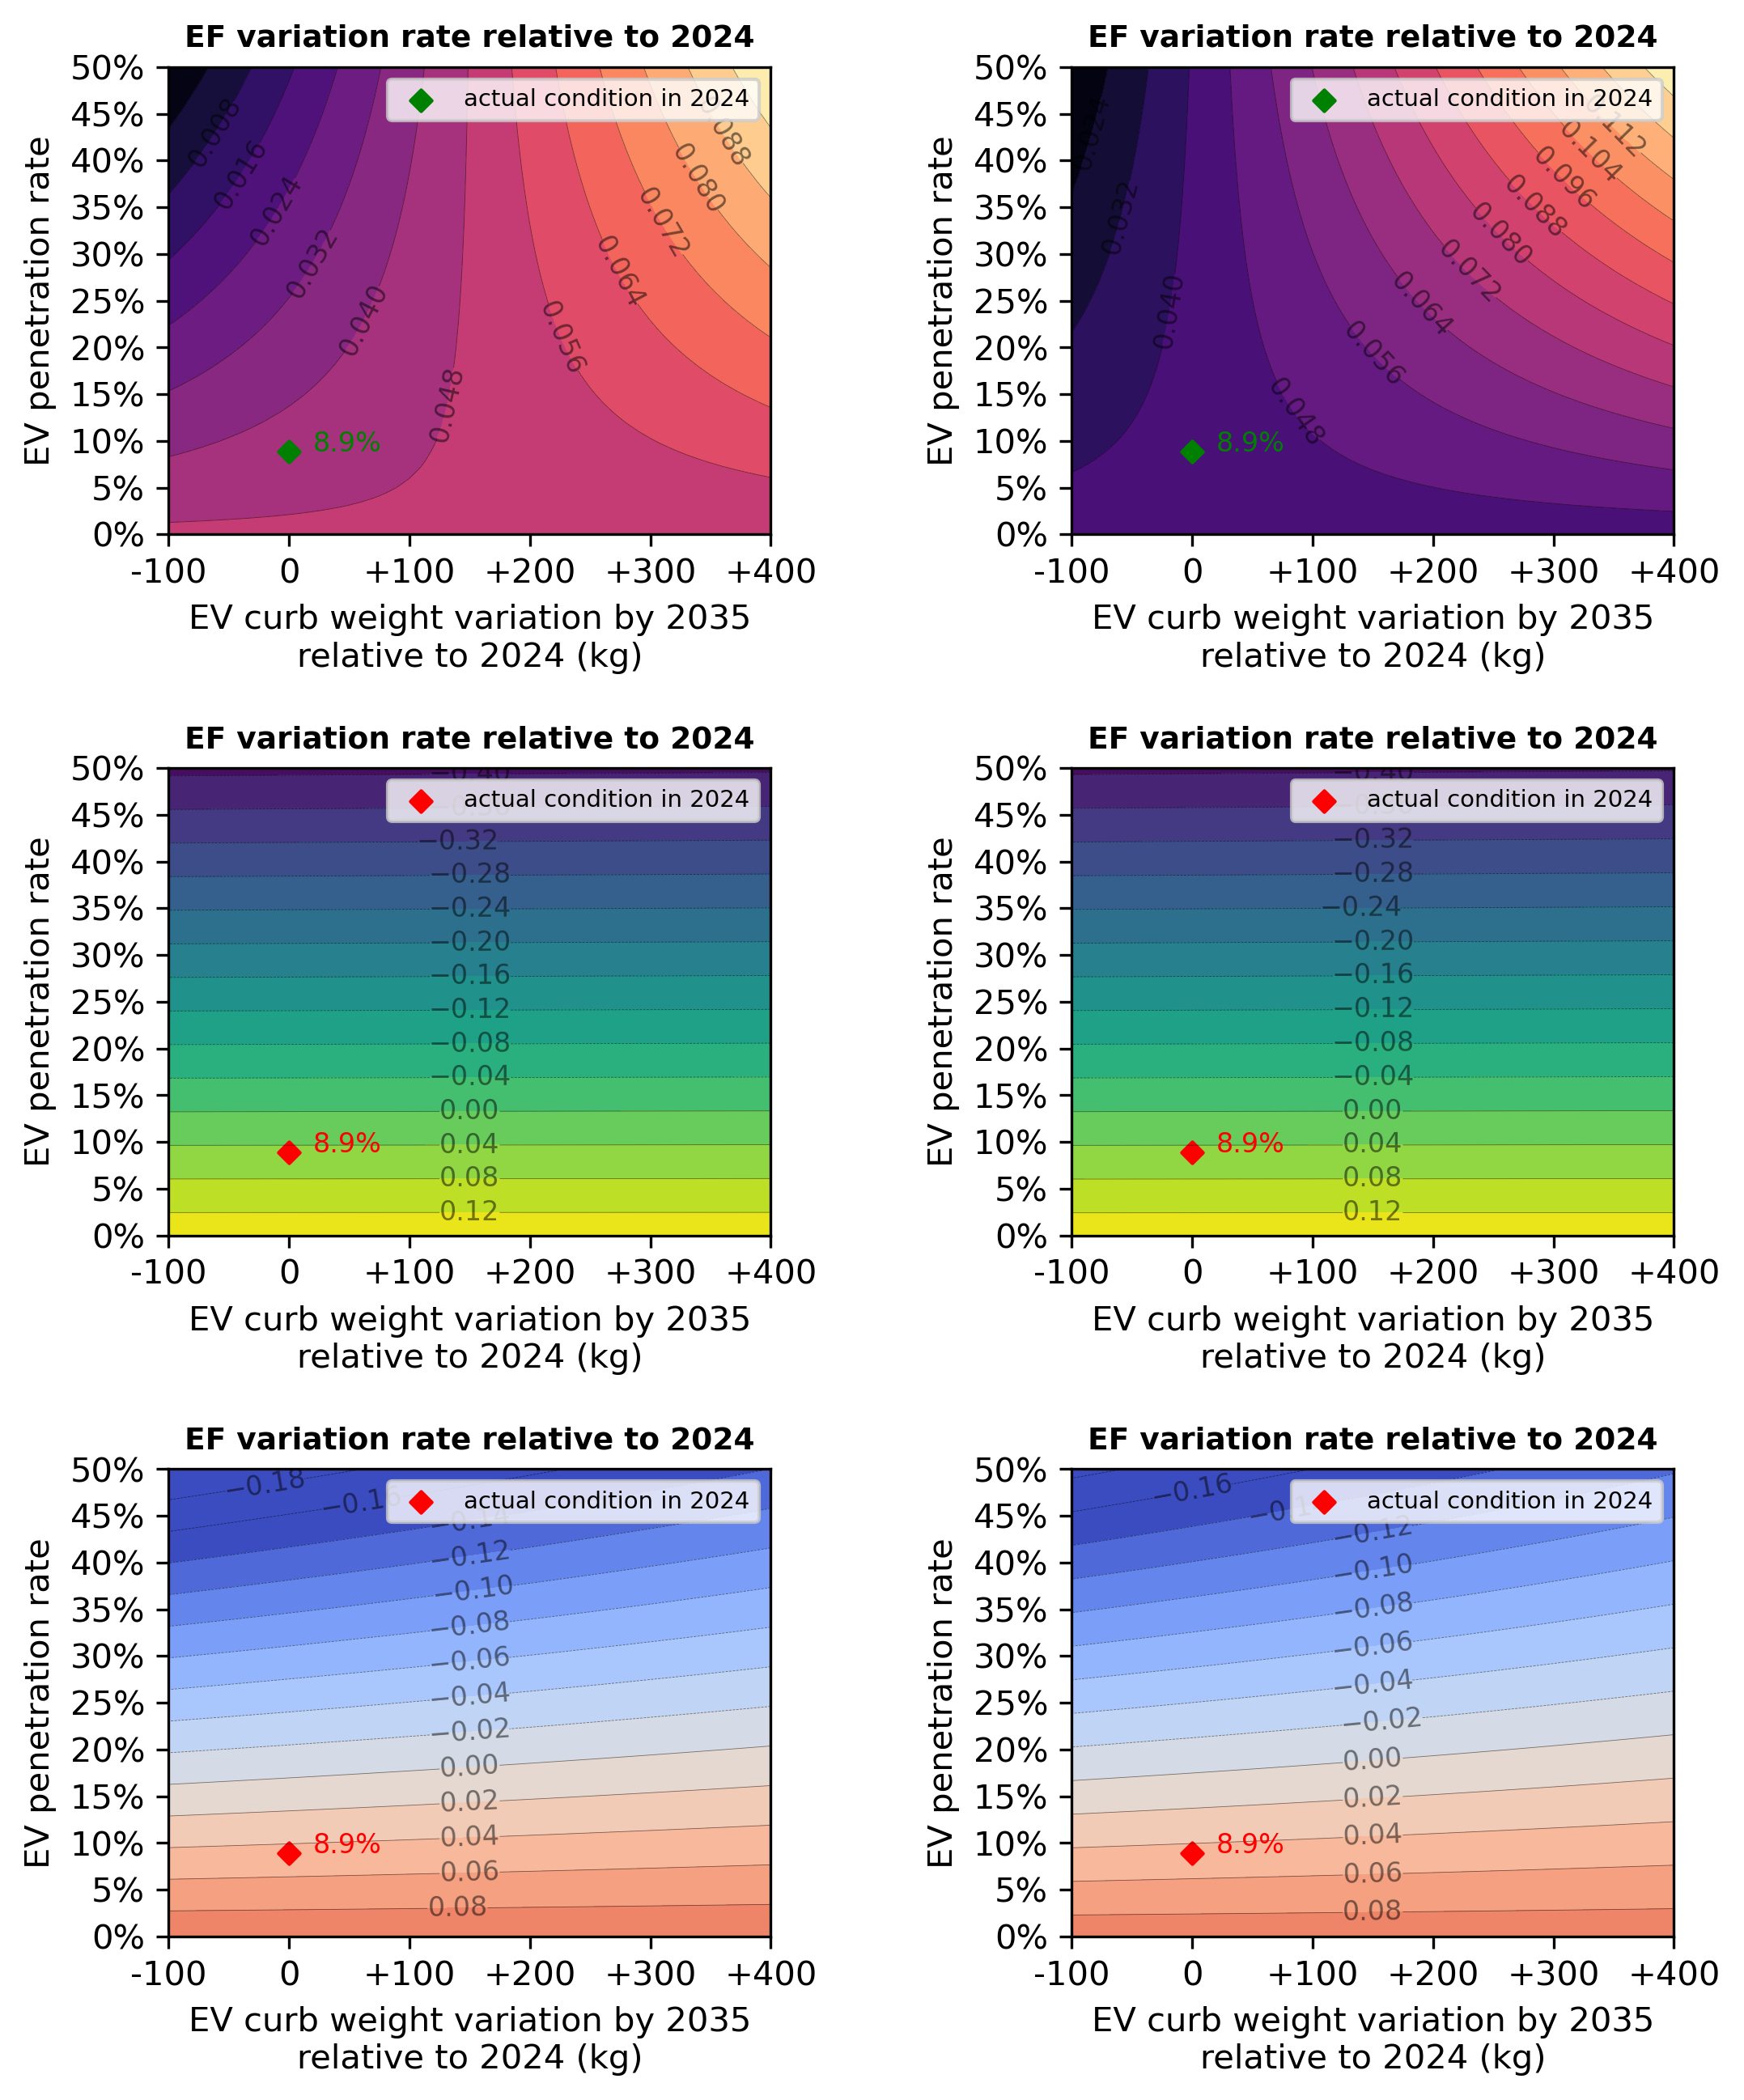

In [40]:
# plot
fig, axes = plt.subplots(3,2,figsize=(8,10))
(ax1, ax2, ax3, ax4, ax5, ax6) = axes.flatten()

x_ticks_range = np.arange(-100, 401, 100)
y_ticks_range = np.arange(0,51,5) / 100 

def contour(ax, ef, ef_name, cmap):
    pivot_ef = ef.pivot(index='penetration', columns='weight inc', values=ef_name)
    X, Y = np.meshgrid(pivot_ef.columns, pivot_ef.index)
    if ef_name == "ef":
        contourf = ax.contourf(X, Y, pivot_ef.values, cmap=cmap, levels=15, vmin=-0.15, vmax=0.15)
        contour = ax.contour(X, Y, pivot_ef.values, colors='k', alpha=0.5, linewidths=0.2, levels=15, vmin=-0.15, vmax=0.15)
    else:
        contourf = ax.contourf(X, Y, pivot_ef.values, cmap=cmap, levels=15)
        contour = ax.contour(X, Y, pivot_ef.values, colors='k', alpha=0.5, linewidths=0.2, levels=15)       
    ax.clabel(contour, inline=True, fontsize=8)
    ax.set_title("EF variation rate relative to 2024", fontsize=9, fontweight='bold')
    ax.set_xlabel('EV curb weight variation by 2035\nrelative to 2024 (kg)')
    ax.set_ylabel('EV penetration rate')
    ax.set_xticks(x_ticks_range, ["+%d"%w if w>0 else w for w in x_ticks_range])
    ax.set_yticks(y_ticks_range, ["%d%%" % pen for pen in y_ticks_range*100], rotation=0)
    ax.set_xlim(-100, 400)

def scatter(ax, ef, ef_name, dot_color):
    # actual penetration in 2024
    ax.scatter([0], [base_penetration], marker='D', color=dot_color, s=20, label='actual condition in 2024')
    ax.text(0+20, base_penetration, '%.1f%%'%(base_penetration*100), ha='left', color=dot_color, fontsize=8)
    # assumed penetration
    # ax.hlines(y=0.20, xmin=-500, xmax=400, color='r', linewidth=1, linestyles='dotted', alpha=0.8, label='assumed EV penetration rate')
    # ax.hlines(y=0.30, xmin=-500, xmax=400, color='r', linewidth=1, linestyles='dotted', alpha=0.8)
    # ax.hlines(y=0.40, xmin=-500, xmax=400, color='r', linewidth=1, linestyles='dotted', alpha=0.8)
    ax.legend(loc='upper right', fontsize=7, shadow=False)

# fig 1: cltc-p weak
contour(ax1, pen_weight_adjust_ef_inc_cltc, "ev weak ef", 'magma')
scatter(ax1, pen_weight_adjust_ef_inc_cltc, "ev weak ef", 'g')
# fig 2: chengdu weak
contour(ax2, pen_weight_adjust_ef_inc_chengdu, "ev weak ef", 'magma')
scatter(ax2, pen_weight_adjust_ef_inc_chengdu, "ev weak ef", 'g')
# fig 3: cltc-p strong
contour(ax3, pen_weight_adjust_ef_inc_cltc, "ev strong ef", 'viridis')
scatter(ax3, pen_weight_adjust_ef_inc_cltc, "ev strong ef", 'r')
# fig 4: chengdu strong
contour(ax4, pen_weight_adjust_ef_inc_chengdu, "ev strong ef", 'viridis')
scatter(ax4, pen_weight_adjust_ef_inc_chengdu, "ev strong ef", 'r')
# fig 6: cltc-p mean
contour(ax5, pen_weight_adjust_ef_inc_cltc, "ef", 'coolwarm')
scatter(ax5, pen_weight_adjust_ef_inc_cltc, "ef", 'r')
# fig 6: chengdu mean
contour(ax6, pen_weight_adjust_ef_inc_chengdu, "ef", 'coolwarm')
scatter(ax6, pen_weight_adjust_ef_inc_chengdu, "ef", 'r')

plt.subplots_adjust(
    wspace=0.5,
    hspace=0.5
)
plt.show()
# fig.savefig('figures/dual impact - weight control.jpg', bbox_inches='tight', dpi=1000)

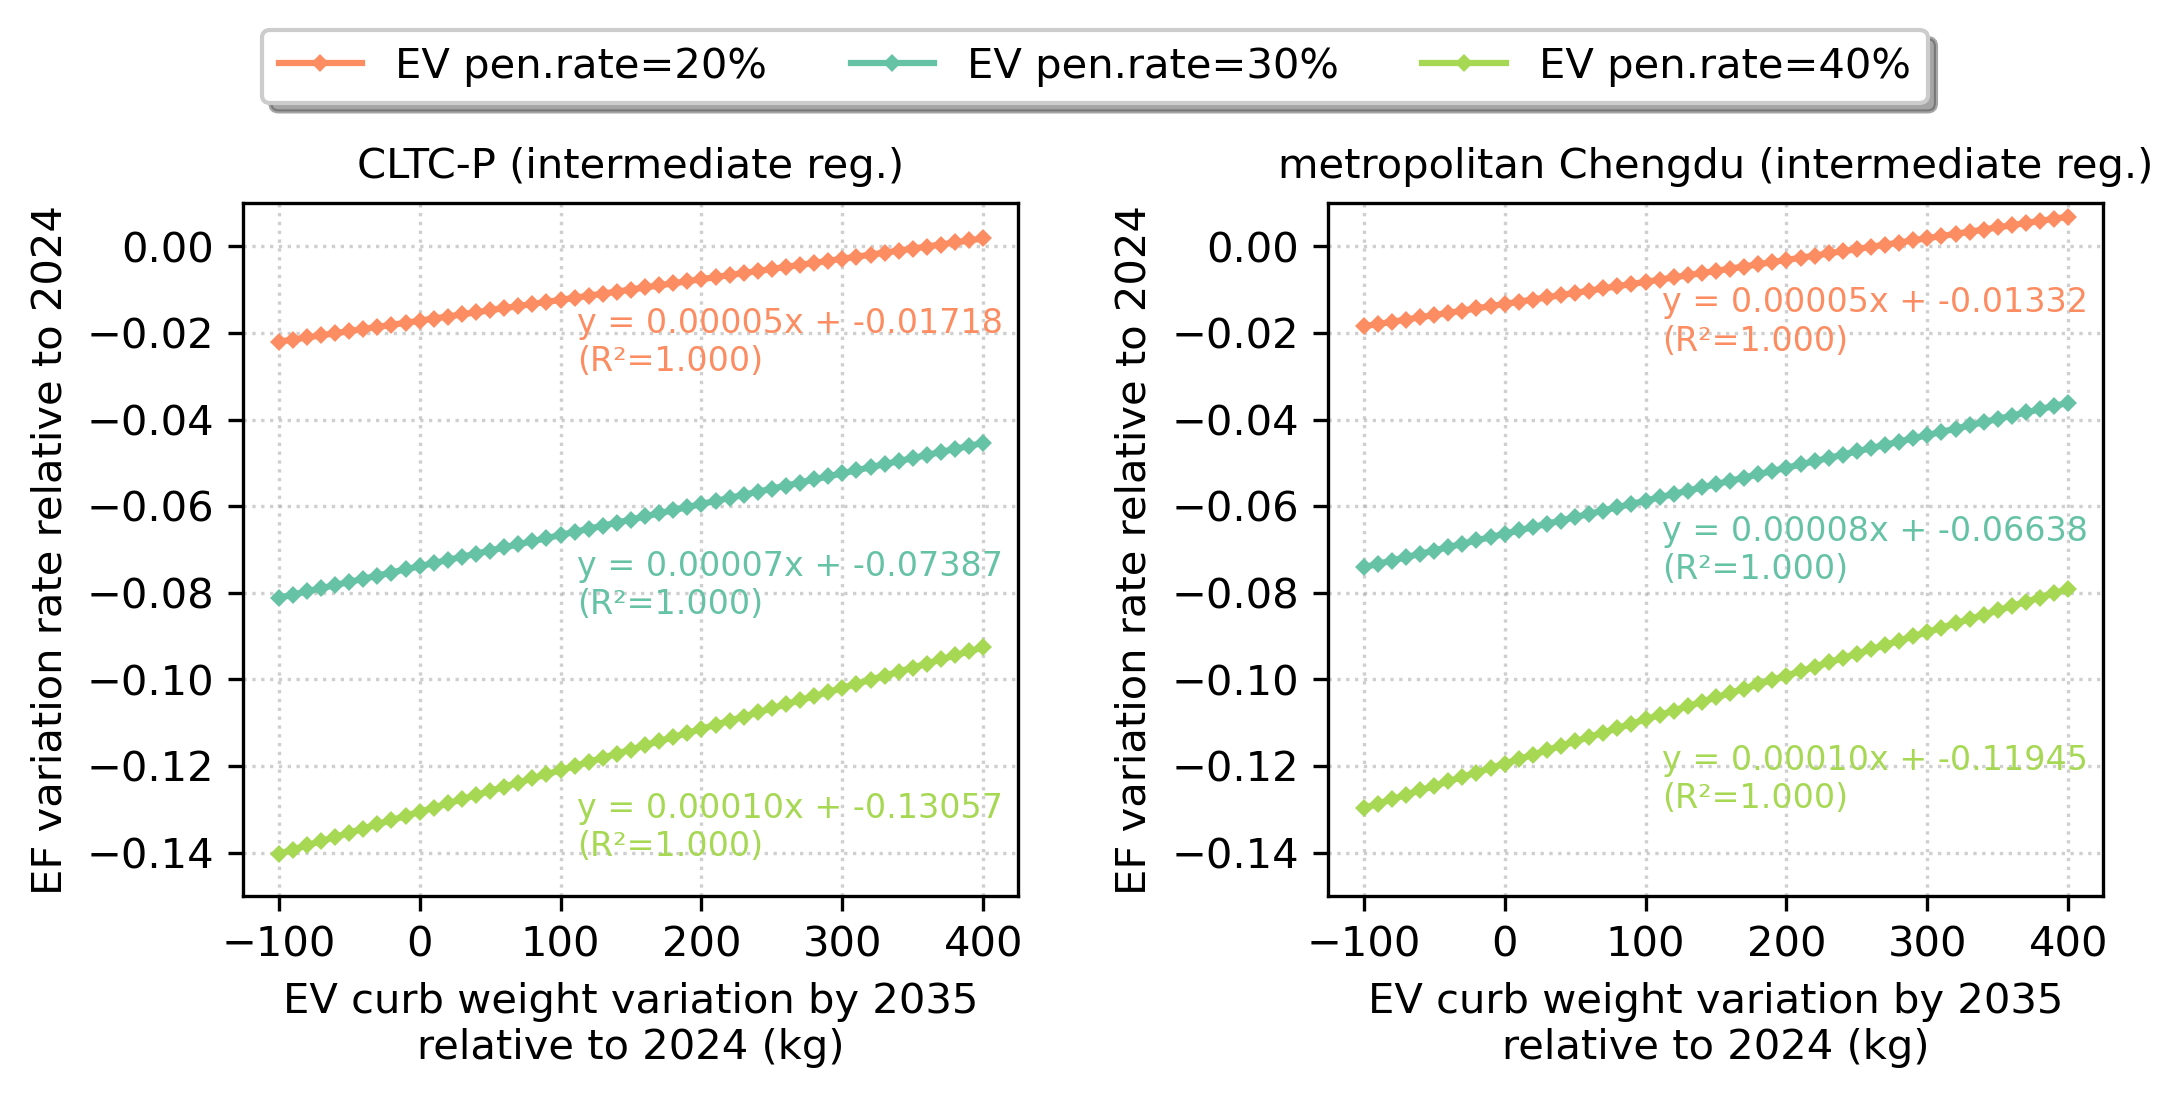

In [ ]:
from scipy.stats import linregress

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))

penetration_values = [0.2,0.3,0.4]
colors = [set2_colors(1), set2_colors(0), set2_colors(4)]

# cltc
for penetration, color in zip(penetration_values, colors):
    ax1.set_title('CLTC-P (intermediate reg.)', fontsize=10)
    # select data
    subset = pen_weight_adjust_ef_inc_cltc[pen_weight_adjust_ef_inc_cltc['penetration'] == penetration]
    subset = subset.sort_values('weight inc')
    # plot
    ax1.plot(subset['weight inc'], subset['ef'], 
             marker='D', linestyle='-', markersize=2, color=color,
             label="EV pen.rate=%d%%" % (penetration*100))
    # regression
    x = subset['weight inc']
    y = subset['ef']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line_eq = f"y = {slope:.5f}x + {intercept:.5f}\n(R²={r_value**2:.3f})"
    ax1.text(0.43, 0.85-0.35 * penetration_values.index(penetration), line_eq,
            transform=ax1.transAxes, fontsize=8, color=color, va='top')

# chengdu
for penetration, color in zip(penetration_values, colors):

    ax2.set_title('metropolitan Chengdu (intermediate reg.)', fontsize=10)
    # select data
    subset = pen_weight_adjust_ef_inc_chengdu[pen_weight_adjust_ef_inc_chengdu['penetration'] == penetration]
    subset = subset.sort_values('weight inc')
    # plot
    ax2.plot(subset['weight inc'], subset['ef'], 
             marker='D', linestyle='-', markersize=2, color=color,
             label=f'penetration={penetration}')
    # regression
    x = subset['weight inc']
    y = subset['ef']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line_eq = f"y = {slope:.5f}x + {intercept:.5f}\n(R²={r_value**2:.3f})"
    ax2.text(0.43, 0.88-0.33 * penetration_values.index(penetration), line_eq,
            transform=ax2.transAxes, fontsize=8, color=color, va='top')

for ax in (ax1, ax2):
    ax.set_ylabel('EF variation rate relative to 2024')
    ax.set_xlabel('EV curb weight variation by 2035\nrelative to 2024 (kg)')
    ax.set_ylim(-0.15, 0.01)
    ax.grid(True, linestyle=':', alpha=0.6)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(2.2 ,1.28), bbox_transform=ax1.transAxes, ncols=3, shadow=True)
plt.subplots_adjust(
    wspace=0.4,
    # hspace=0.5
)
plt.show()
# fig.savefig('figures/dual impact - weight control regression.jpg', bbox_inches='tight', dpi=1000)

In [42]:
pen_weight_adjust_ef_inc_cltc[(pen_weight_adjust_ef_inc_cltc['penetration'] == 0.2) & (pen_weight_adjust_ef_inc_cltc['weight inc'].isin([-200, -100, 0, 100, 200, 300, 400]))]

,weight inc,penetration,ev weak ef,ev strong ef,ef
typing.Literal[<no_default>],,,,,
1020,-100.0,0.2,0.026686,-0.075287,-0.022029
1030,0.0,0.2,0.035674,-0.074958,-0.017178
1040,100.0,0.2,0.044577,-0.074632,-0.012372
1050,200.0,0.2,0.053404,-0.074308,-0.007608
1060,300.0,0.2,0.062161,-0.073987,-0.002881
1070,400.0,0.2,0.070852,-0.073669,0.001810


In [43]:
pen_weight_adjust_ef_inc_cltc[(pen_weight_adjust_ef_inc_cltc['penetration'] == 0.28) & (pen_weight_adjust_ef_inc_cltc['weight inc'].isin([-100, 0, 100, 200, 300, 400]))]

,weight inc,penetration,ev weak ef,ev strong ef,ef
typing.Literal[<no_default>],,,,,
1428,-100.0,0.28,0.017573,-0.164330,-0.069327
1438,0.0,0.28,0.030155,-0.163869,-0.062536
1448,100.0,0.28,0.042621,-0.163412,-0.055807
1458,200.0,0.28,0.054979,-0.162959,-0.049137
1468,300.0,0.28,0.067237,-0.162510,-0.042520
1478,400.0,0.28,0.079405,-0.162064,-0.035952
